In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [91]:
from scipy.stats import poisson

In [3]:
def read_data(filename):
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

In [4]:
df2011 = read_data("https://github.com/AllenDowney/ThinkBayes2/blob/master/data/showcases.2011.csv?raw=true")
df2012 = read_data("https://github.com/AllenDowney/ThinkBayes2/blob/master/data/showcases.2012.csv?raw=true")

df = pd.concat([df2011, df2012], ignore_index=True)
df.head(3)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0


In [92]:
print(df.shape)

(313, 6)


In [7]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf

In [8]:
def kde_from_sample(sample, qs):
    """Estimate a kernel density object from a sample."""
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [9]:
# Use kde to estimate dist of values for Showcase 1

qs = np.linspace(0, 80000, 81) # assuming the upper limit here is derived by looking empirically at the max of Showcase 1

prior1 = kde_from_sample(df["Showcase 1"], qs)

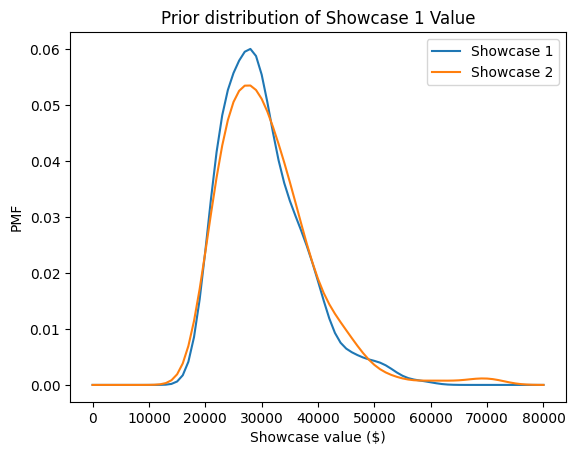

In [14]:
prior1.plot(label="Showcase 1", title="Prior distribution of Showcase 1 Value", xlabel="Showcase value ($)", ylabel="PMF")
prior2.plot(label="Showcase 2")
plt.legend()

In [11]:
df["Showcase 1"].max()

np.float64(58342.0)

In [12]:
df["Showcase 2"].max()

np.float64(71628.0)

In [13]:
# Exercise 9-1

prior2 = kde_from_sample(df["Showcase 2"], qs)

In [15]:
# If the actual price is PR, what is the likelihood that the guess will be GS?
# or, if error ER = GU - PR, what is the likelihood that the guess is off by ER?

# Using historical data

sample_diff1 = df["Bid 1"] - df["Showcase 1"]
sample_diff2 = df["Bid 2"] - df["Showcase 2"]

In [16]:
# Use kde to visualize the distributions of these diffferences

qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

<Axes: title={'center': 'Difference between bid and actual price'}, xlabel='Difference ($)', ylabel='PMF'>

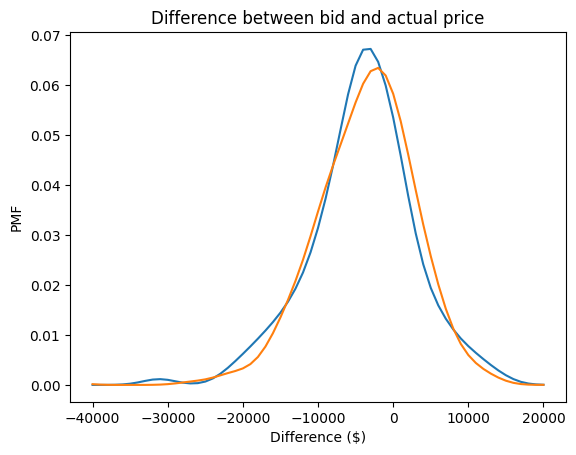

In [17]:
kde_diff1.plot(label="Diff 1", title="Difference between bid and actual price")
kde_diff2.plot(label="Diff 2", xlabel="Difference ($)", ylabel="PMF")

In [18]:
# These distributions can be used to model each contestants distribution of errors

mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

print(mean_diff1, std_diff1)

-4116.3961661341855 6899.909806377117


In [19]:
from scipy.stats import norm

In [20]:
error_dist1 = norm(0, std_diff1)

In [21]:
error = -100
error_dist1.pdf(error)

np.float64(5.781240564008691e-05)

In [22]:
# If you see a showcase and your guess is $23000

guess1 = 23000

# From this guess we subtract away each hypothetical price in the prior, to calculate your error under each hypothesis

error1 = guess1 - prior1.qs

In [23]:
# To calculate the likelihood, we assume that your estimation error is well-approximated by error_dist1
# We compute the likelihood of your error under each hypothesis

likelihood1 = error_dist1.pdf(error1)

In [24]:
# This array of likelihoods is used to update the prior

posterior1 = prior1 * likelihood1
posterior1.normalize()

np.float64(3.3889812097254624e-05)

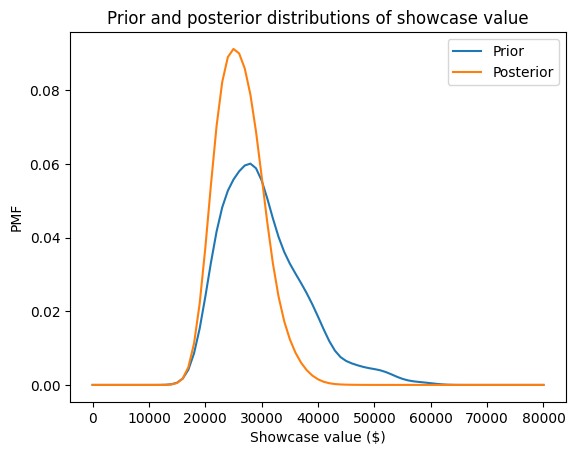

In [26]:
prior1.plot(label="Prior", title="Prior and posterior distributions of showcase value")
posterior1.plot(label="Posterior", xlabel="Showcase value ($)", ylabel="PMF")
plt.legend()

In [27]:
prior1.mean(), posterior1.mean()

(np.float64(30299.488817891375), np.float64(26192.024002392536))

In [28]:
# Exercise 9-2

mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()

print(mean_diff2, std_diff2)

-3675.891373801917 6886.260711323408


In [29]:
error_dist2 = norm(0, std_diff2)

In [30]:
guess2 = 38000

error2 = guess2 - prior2.qs

likelihood2 = error_dist2.pdf(error2)

posterior2 = prior2 * likelihood2
posterior2.normalize()

np.float64(2.697812321910702e-05)

In [31]:
prior2.mean(), posterior2.mean()

(np.float64(31047.62371912251), np.float64(34305.20161642469))

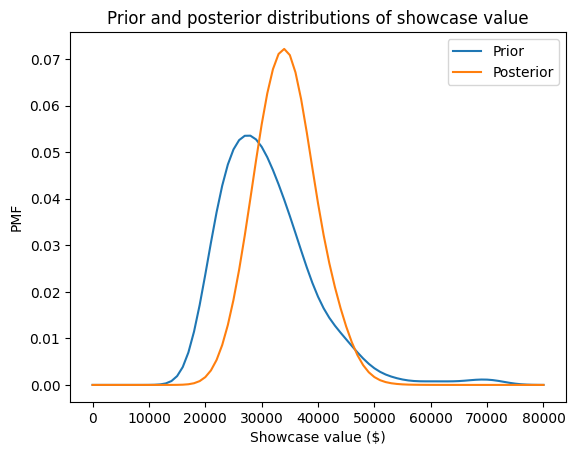

In [32]:
prior2.plot(label="Prior", title="Prior and posterior distributions of showcase value")
posterior2.plot(label="Posterior", xlabel="Showcase value ($)", ylabel="PMF")
plt.legend()

In [33]:
# Function that takes a sequence of past bids and returns the fraction of overbids

def prob_overbid(sample_diff):
    """Computes pr(overbid)"""
    return np.mean(sample_diff > 0)

In [34]:
prob_overbid(sample_diff2)

np.float64(0.29073482428115016)

In [35]:
# If player 1 underbids by $5000, what is the probability of player 2 underbids by more?

def prob_worse_than(diff, sample_diff):
    """Pr(opponent bid is worse than a given diff)"""
    return np.mean(sample_diff < diff)

In [36]:
# Prob that player 2 underbids by more than $5000

prob_worse_than(-5000, sample_diff2)

np.float64(0.38338658146964855)

In [37]:
prob_worse_than(-10000, sample_diff2)

np.float64(0.14376996805111822)

In [38]:
# These functions can be combined to compute pr(player 1 wins) given the diff between their bid and actual price

def compute_prob_win(diff, sample_diff):
    """Pr(win) for a given diff"""
    # If you overbid, you lose
    if diff > 0:
        return 0
    
    # If opponent overbids OR their bid is worse than yours, you win
    p1 = prob_overbid(sample_diff)
    p2 = prob_worse_than(diff, sample_diff)
    
    return p1 + p2 # these probabilities can be added since they're mutually exclusive

In [39]:
# Prob that you win given that you underbid by $5000

compute_prob_win(-5000, sample_diff2)

np.float64(0.6741214057507987)

In [40]:
# The prob of winning for a range of possible differences

xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) for x in xs]

Text(0.5, 1.0, 'Player 1')

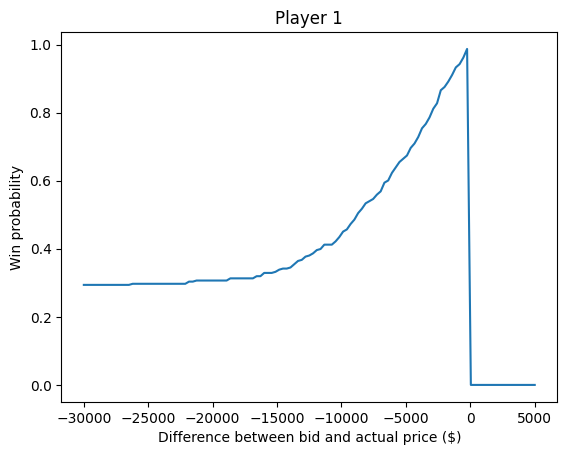

In [43]:
plt.plot(xs, ys)
plt.xlabel("Difference between bid and actual price ($)")
plt.ylabel("Win probability")
plt.title("Player 1")

In [44]:
# Exercise 9-3 - the same analysis from Player 2's perspective

# Prob that player 1 overbids

prob_overbid(sample_diff1)

np.float64(0.24600638977635783)

In [45]:
# Prob that player 1 underbids by more than $5000

prob_worse_than(-5000, sample_diff1)

np.float64(0.3993610223642173)

In [46]:
# Prob that player 2 wins given a $5000 underbid

compute_prob_win(-5000, sample_diff1)

np.float64(0.6453674121405751)

Text(0.5, 1.0, 'Player 2')

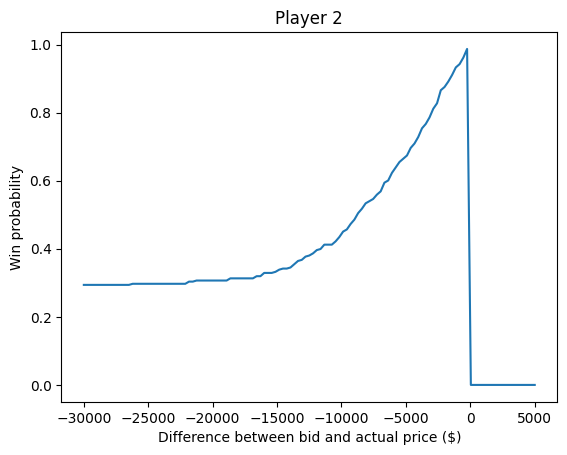

In [47]:
ys2 = [compute_prob_win(x, sample_diff1) for x in xs]

plt.plot(xs, ys)
plt.xlabel("Difference between bid and actual price ($)")
plt.ylabel("Win probability")
plt.title("Player 2")

In [48]:
# We've estimated posterior distributions representing beliefs about the actual price, 
# which can be used to estimate the probability of winning with a given bid

# This function takes a bid, a posterior of actual prices, and sample differences for the other player,
# then loops through the hypothetical prices in the posterior to compute:
# 1. Diff between the bid and the hypothetical price
# 2. Pr(player wins | difference)
# 3. Weighted sum of the probabilities, where the weights are the probs in the posterior

def total_prob_win(bid, posterior, sample_diff):
    """Computes total probability of winning with a given bid
    
       bid: your bid
       posterior: Pmf of showcase value
       sample_diff: sequence of differences for the opponent
       
       returns prob of winning"""
    total = 0
    for price, prob in posterior.items():
        diff = bid - price
        total += prob * compute_prob_win(diff, sample_diff) # This is the law of total probability
    return total

In [49]:
# Prob that player wins with a bid of $25000

total_prob_win(25000, posterior1, sample_diff2)

np.float64(0.4842210945439812)

In [50]:
# Loop through a series of possible bids and compute win prob for each one

bids = posterior1.qs
probs = [total_prob_win(bid, posterior1, sample_diff2) for bid in bids]

prob_win_series = pd.Series(probs, index=bids)

<Axes: title={'center': 'Optimal bid for Player 1'}, xlabel='Bid ($)', ylabel='Win probability'>

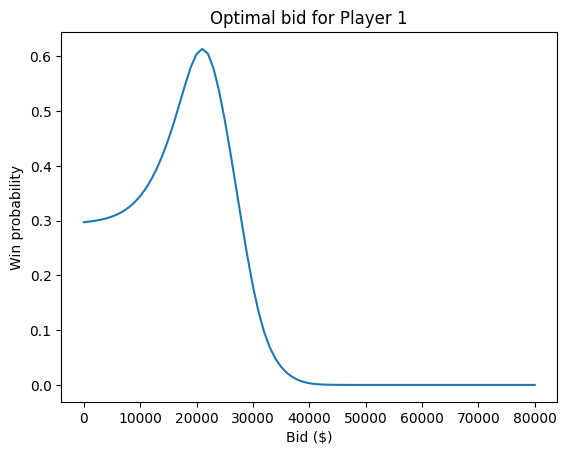

In [51]:
prob_win_series.plot(title="Optimal bid for Player 1", xlabel="Bid ($)", ylabel="Win probability")

In [52]:
prob_win_series.idxmax() # This bid maximizes Player 1's chances of winning. Note this is different from the posterior mean of $26000

np.float64(21000.0)

In [53]:
prob_win_series.max() # This is the probability of winning with the best possible bid

np.float64(0.6136807192359474)

In [54]:
# Exercise 9-4 - the above exercise for Player 2

# Presumably this means looping through a series of possible bids and computing win prob for each one?

bids = posterior2.qs
probs = [total_prob_win(bid, posterior2, sample_diff1) for bid in bids]

prob_win_series = pd.Series(probs, index=bids)

<Axes: title={'center': 'Optimal bid for Player 2'}, xlabel='Bid ($)', ylabel='Win probability'>

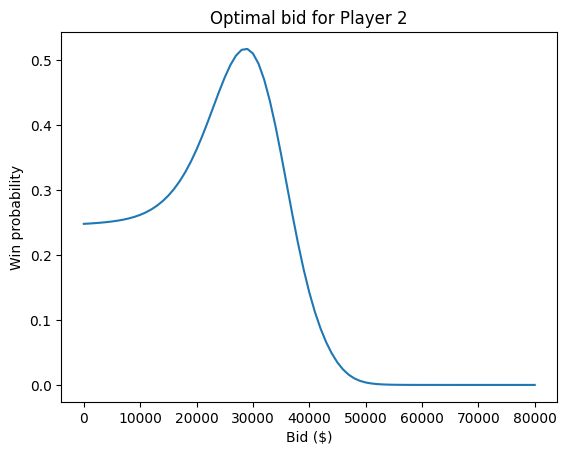

In [55]:
prob_win_series.plot(title="Optimal bid for Player 2", xlabel="Bid ($)", ylabel="Win probability")

In [56]:
prob_win_series.idxmax()

np.float64(29000.0)

In [57]:
prob_win_series.max()

np.float64(0.5171370053364229)

In [60]:
# If your bid is off by <$250 you win both showcases, so you might want to increase your bid slightly

def compute_gain(bid, price, sample_diff):
    """Compute expected gain given a bid and an actual price"""
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)
    
    # If you are within 250 dollars you win both showcases
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

In [61]:
compute_gain(30000, 35000, sample_diff2)

np.float64(23594.249201277955)

In [62]:
# We don't know the actual price, but we can average over the prices and probabilities in our posterior to 
# compute expected gain for a given bid

def expected_gain(bid, posterior, sample_diff):
    """Compute expected gain of a given bid"""
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

In [63]:
# Based on our earlier posterior calculated based on a guess of $23000

expected_gain(21000, posterior1, sample_diff2)

np.float64(16923.59933856512)

In [64]:
# We can loop through a range of bids to find out which one maximizes expected gain

bids = posterior1.qs
gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]
expected_gain_series = pd.Series(gains, index=bids)

<Axes: title={'center': 'Optimal bid for Player 1'}, xlabel='Bid ($)', ylabel='Expected gain ($)'>

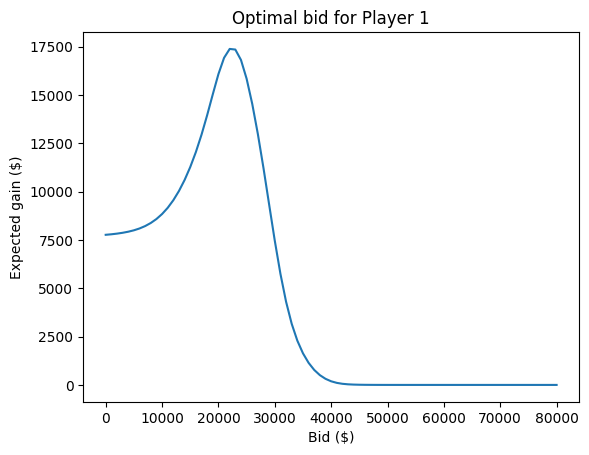

In [65]:
expected_gain_series.plot(title="Optimal bid for Player 1", xlabel="Bid ($)", ylabel="Expected gain ($)")

In [66]:
expected_gain_series.idxmax()

np.float64(22000.0)

In [67]:
expected_gain_series.max()

np.float64(17384.899584430797)

In [68]:
# Exercise 9-5 - same analysis for Player 2

bids = posterior2.qs
gains = [expected_gain(bid, posterior2, sample_diff1) for bid in bids]
expected_gain_series = pd.Series(gains, index=bids)

<Axes: title={'center': 'Optimal bid for Player 2'}, xlabel='Bid ($)', ylabel='Expected gain ($)'>

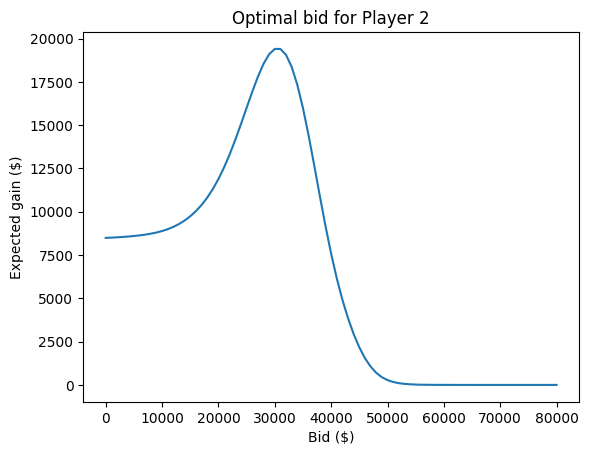

In [69]:
expected_gain_series.plot(title="Optimal bid for Player 2", xlabel="Bid ($)", ylabel="Expected gain ($)")

In [70]:
expected_gain_series.idxmax()

np.float64(30000.0)

In [71]:
expected_gain_series.max()

np.float64(19404.164188501607)

In [73]:
# Exercise 9-6 - I can really sit with this as the solution is worked out on colab. It is WAY too complex to have intuited.

# The solution begins with modeling decisions.
# Passenger arrivals are treated as a Poisson process: people are equally likely to arrive at any time at a constant rate lam (passengers/min)
# But train arrivals are not Poisson. By the time they get from Alewife to Kendall arrivals vary between 3 and 12 mins (mean 7-8)
# The solution downloaded data from MBTA, 4pm-6pm for 5 weekdays, recording about 15 arrivals/day
# Then computed gap times between arrivals in seconds

observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

# They're then converted to mins, and KDE is used to estimate the distribution

zs = np.array(observed_gap_times) / 60
qs = np.linspace(0, 20, 101)
pmf_z = kde_from_sample(zs, qs)

<Axes: title={'center': 'Distribution of time between trains'}, xlabel='Time (min)', ylabel='PDF'>

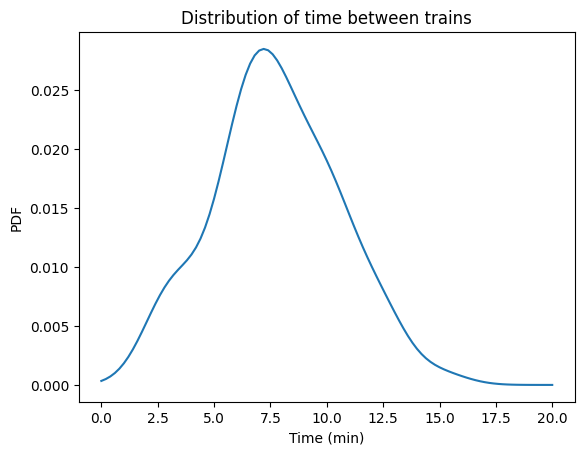

In [74]:
pmf_z.plot(title="Distribution of time between trains", xlabel="Time (min)", ylabel="PDF") # Not PMF?

In [75]:
# Assume you arrive at the station and see 10 passengers - what is the expected dist of wait times?
# This question is answered in 2 steps:
# 1. Derive distribution of wait times as observed by a random passenger
# 2. Derive distribution of wait times conditional on the number of passengers
# For 1, you're more likely to arrive in a long gap than a short one - pr of arriving in any interval is proportional to the interval's duration

# If we think of pmf_z as a distribution of gap time, the likelihood of arriving during a gap is the duration of the gap
likelihood = pmf_z.qs

In [76]:
# Using this as a likelihood, first Bayesian update

posterior_z = pmf_z * pmf_z.qs
posterior_z.normalize()

np.float64(7.772927524715935)

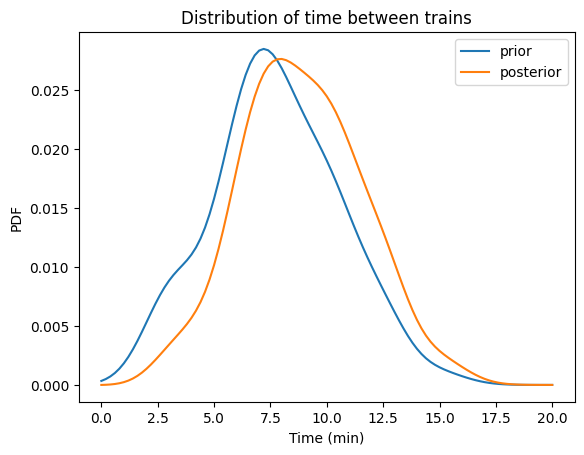

In [78]:
pmf_z.plot(label="prior", title="Distribution of time between trains")
posterior_z.plot(label="posterior", xlabel="Time (min)", ylabel="PDF")
plt.legend()

In [79]:
pmf_z.mean(), posterior_z.mean() # I'm more likely to arrive in a longer gap, so the dist shifts to the right

(np.float64(7.772927524715935), np.float64(8.89677416786441))

In [80]:
# Elapsed time x = time between prior train arrival and the passenger's arrival
# Wait time y = time between passenger arrival and the next train arrival

#z = x + y # z being the total gap time - this throws an error since x isn't defined

# Simple case
# Assume the gap between trains is either 5 or 10 mins with equal probability
# Since we're more likely to arrive in a longer interval, Pr(arriving in 5 gap)=1/3, Pr(arriving in 10 gap)=2/3
# If we arrive in a 5 min gap, x is uniform from 0-5 mins
# If we arrive in a 10 min gap, x is uniform from 0-10 mins. So the wait time dist is a weighted mix of 2 uniforms
# If we have the posterior of z, we can compute the dist of x as a mixture of uniforms

NameError: name 'x' is not defined

In [81]:
def make_elapsed_dist(gap, qs):
    qs = qs[qs <= gap]
    n = len(qs)
    return Pmf(1/n, qs)

In [82]:
qs = posterior_z.qs
pmf_seq = [make_elapsed_dist(gap, qs) for gap in qs] # This makes a sequence of Pmfs for each gap in posterior_z

<Axes: title={'center': 'Distribution of wait time in 20-min gap'}, xlabel='Time (mins)', ylabel='PDF'>

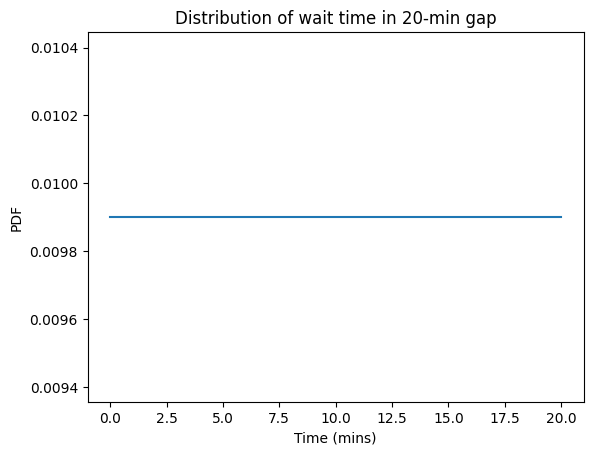

In [84]:
# The last element of pmf_seq is uniform from 0-20 mins
pmf_seq[-1].plot(title="Distribution of wait time in 20-min gap", xlabel="Time (mins)", ylabel="PDF")

In [86]:
# Use make_mixture to make a weighted mix of uniform distributions
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [87]:
pmf_x = make_mixture(posterior_z, pmf_seq)

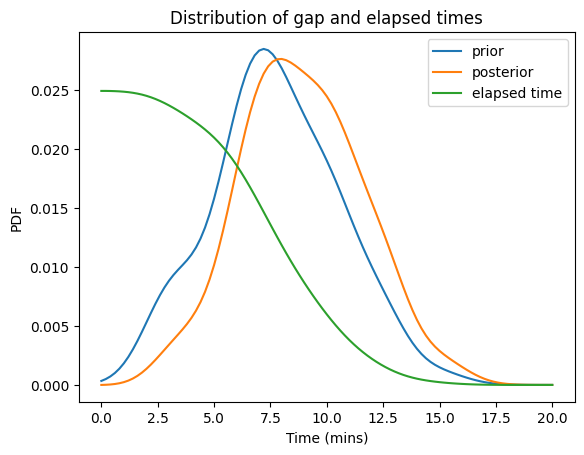

In [88]:
pmf_z.plot(label="prior", title="Distribution of gap and elapsed times")
posterior_z.plot(label="posterior", xlabel="Time (mins)")
pmf_x.plot(label="elapsed time", ylabel="PDF")
plt.legend()

In [89]:
posterior_z.mean(), pmf_x.mean() # The elapsed time is about half the gap time on average, which makes sense, since we assume we arrive in the middle of the interval

(np.float64(8.89677416786441), np.float64(4.448387083932206))

In [93]:
# Now we account for the number of passengers on the platform
# Assume they arrive at a constant rate lam of 2 passengers/min

lam = 2
num_passengers = 10
likelihood = poisson(lam * pmf_x.qs).pmf(num_passengers)

In [94]:
# We then compute the posterior of x
posterior_x = pmf_x * likelihood
posterior_x.normalize()

np.float64(0.04757676716097804)

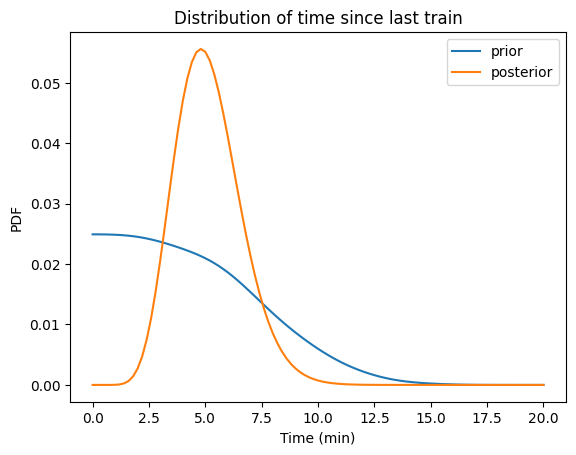

In [95]:
pmf_x.plot(label="prior", title="Distribution of time since last train")
posterior_x.plot(label="posterior", xlabel="Time (min)", ylabel="PDF")
plt.legend()

In [96]:
pmf_x.mean(), posterior_x.mean() # Based on observing 10 passengers, we assume it's been 5 minutes since the last train

(np.float64(4.448387083932206), np.float64(5.143935076179749))

In [97]:
# If we know x and z, we can compute y = z - x
posterior_y = Pmf.sub_dist(posterior_z, posterior_x)

nonnegative = (posterior_y.qs >= 0)
posterior_y = Pmf(posterior_y[nonnegative])
posterior_y.normalize()

np.float64(0.8900343090047254)

<Axes: title={'center': 'Distribution of elapsed, wait, gap times'}, xlabel='Time (min)', ylabel='PDF'>

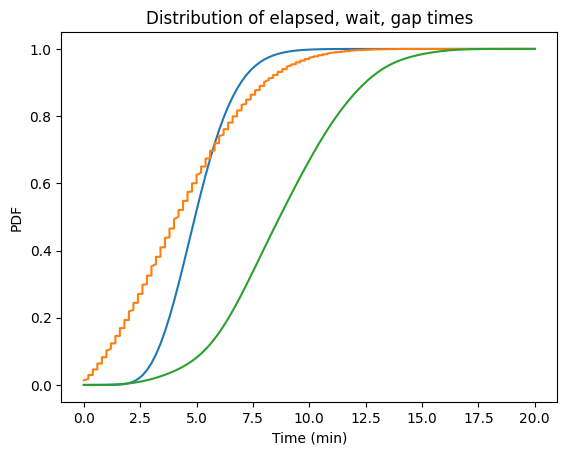

In [99]:
# We can display the posteriors of x, y, and z as CDFs
# Because of rounding errors posterior_y contains values not in the other posteriors;
# this is why we plot as CDFs, and why it's not a smooth curve

posterior_x.make_cdf().plot(label="posterior of elapsed time", xlabel="Time (min)")
posterior_y.make_cdf().plot(label="posterior of wait time", ylabel="PDF")
posterior_z.make_cdf().plot(label="posterior of gap time", title="Distribution of elapsed, wait, gap times")

In [100]:
# Now we can use the number of passengers on the platform to predict distribution of wait times
# Assumption that you leave the office early enough to wait 15 minutes and still catch the commuter rail
# So we want to know prob that y>15 mins as a function of the number of passengers
# We can run the previous analysis with a distribution of num_passengers values

# Problem: this is sensitive to the frequency of long delays, which are rare
# Previous observations can be used to make a rough estimate
# We can augment the observed dist of gap times with assumptions about long delays
# Draw a sample of 260 values from posterior_z (num work days/yr), and add in 3 long delays I observed in a year

sample = posterior_z.sample(260)
delays = [30, 40, 50]
augmented_sample = np.append(sample, delays)

# And use this to make a new estimate of posterior_z

qs = np.linspace(0, 60, 101)
augmented_posterior_z = kde_from_sample(augmented_sample, qs)

<Axes: title={'center': 'Augmented posterior of z'}, xlabel='Time (mins)', ylabel='PDF'>

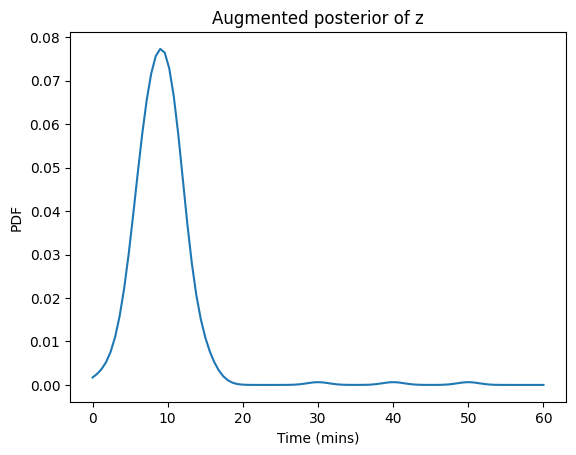

In [101]:
augmented_posterior_z.plot(title="Augmented posterior of z", xlabel="Time (mins)", ylabel="PDF")

In [102]:
# Now we wrap the previous analysis in a function

qs = augmented_posterior_z.qs
pmf_seq = [make_elapsed_dist(gap, qs) for gap in qs]
pmf_x = make_mixture(augmented_posterior_z, pmf_seq)
lam = 2
num_passengers = 10

In [103]:
def compute_posterior_y(num_passengers):   
    """Distribution of wait time based on `num_passengers`."""
    likelihood = poisson(lam * qs).pmf(num_passengers)
    posterior_x = pmf_x * likelihood
    posterior_x.normalize()
    posterior_y = Pmf.sub_dist(augmented_posterior_z, posterior_x)
    nonneg = (posterior_y.qs >= 0)
    posterior_y = Pmf(posterior_y[nonneg])
    posterior_y.normalize()
    return posterior_y

In [104]:
# We can call this function with eg 10 passengers and estimate a posterior wait time mean and CDF
# But we want to sweep through a range of num_passengers values

nums = np.arange(0, 37, 3)
posteriors = [compute_posterior_y(num) for num in nums]

In [105]:
# The mean wait time as a function of the number of passengers
mean_wait = [posterior_y.mean() for posterior_y in posteriors]

Text(0.5, 1.0, 'Expected wait time until next train based on number of passengers')

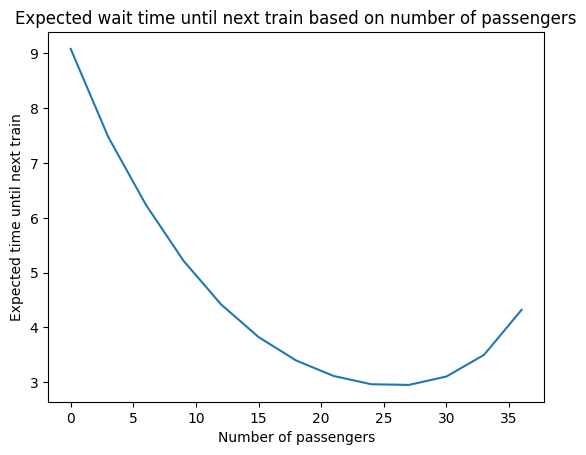

In [106]:
plt.plot(nums, mean_wait)
plt.xlabel("Number of passengers")
plt.ylabel("Expected time until next train")
plt.title("Expected wait time until next train based on number of passengers")

In [107]:
# What is the probability that the wait time exceeds 15 minutes?

prob_late = [1 - posterior_y.make_cdf()(15) for posterior_y in posteriors]

Text(0.5, 1.0, 'Probability of being late based on number of passengers')

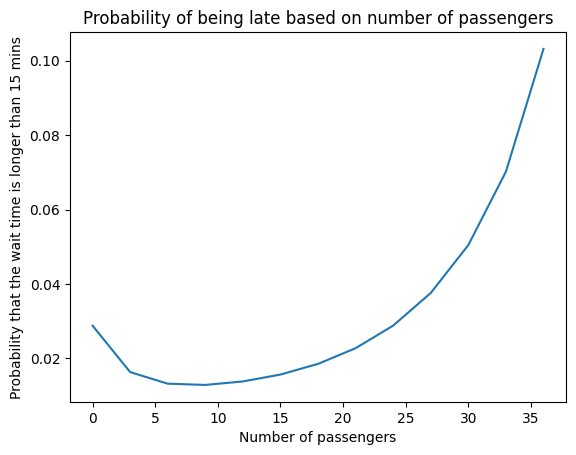

In [108]:
plt.plot(nums, prob_late)
plt.xlabel("Number of passengers")
plt.ylabel("Probability that the wait time is longer than 15 mins")
plt.title("Probability of being late based on number of passengers")

In [109]:
# Exercise 9-7 - this literally can't be solved without the author's solution

# Say we start selling online. We sell 10 books in week 1, 9 books in week 2. Assume the sales are a Poisson process.
# So weekly orders are samples from a Poisson distribution with unknown lambda, but past orders can be used to estimate lambda
# Then a predicted distribution for future weeks, and the order size that maximizes profit

# Assumptions: printing 1 book costs $5, but $4.50 if you order 100 or more
# Each sale brings in $10
# If we run out of books before 8 weeks, we lose $50 for each week we're out of stock
# If we have books left after 8 weeks, we lose $2 in inventory costs per extra book

# Start with functions computing costs and profits

def print_cost(printed):
    if printed < 100:
        return printed * 5
    else:
        return printed * 4.5

In [110]:
def total_income(printed, orders):
    sold = min(printed, np.sum(orders))
    return sold * 10

In [111]:
def inventory_cost(printed, orders):
    excess = printed - np.sum(orders)
    if excess > 0:
        return excess * 2
    else:
        return 0

In [112]:
def out_of_stock_cost(printed, orders):
    weeks = len(orders)
    total_orders = np.cumsum(orders)
    for i, total in enumerate(total_orders):
        if total > printed:
            return (weeks - i) * 50
    return 0

In [116]:
def compute_profit(printed, orders):
    return (total_income(printed, orders) - print_cost(printed) - inventory_cost(printed, orders)
           - out_of_stock_cost(printed, orders))

In [114]:
# Test this out by assuming we get 10 orders a week for 8 weeks

always_10 = [10] * 8
always_10

[10, 10, 10, 10, 10, 10, 10, 10]

In [117]:
# Then assume we print 60 books
compute_profit(60, always_10)

200

In [118]:
# If we print 100 books
compute_profit(100, always_10)

np.float64(310.0)

In [120]:
# But we don't know how many books will be ordered in a given week, or the average rate of orders
# The solution makes an arbitrary assumption that order rates are distributed gamma with alpha = 9

from scipy.stats import gamma

alpha = 9
qs = np.linspace(0, 25, 101)
ps = gamma.pdf(qs, alpha)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.mean()

np.float64(8.998788382371902)

<Axes: xlabel='Book ordering rate ($\\lambda$)', ylabel='PMF'>

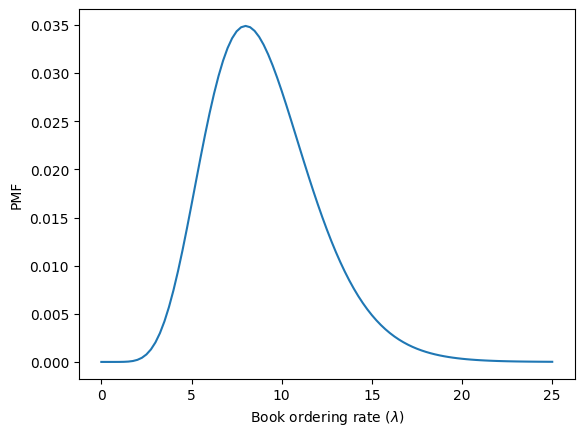

In [121]:
pmf.plot(xlabel="Book ordering rate ($\lambda$)", ylabel="PMF")

In [122]:
# We COULD generate a predicted distribution for numbers of books ordered in a given week, but the cost
# function is complicated (esp out of stock cost, which depends on the sequence of orders)

# So the solution suggests running simulations instead
# We draw a random sample of 1000 values from the ordering rate PMF

rates = pmf.choice(1000)
np.mean(rates)

np.float64(8.914)

In [124]:
# For each possible rate, we generate a sequence of 8 orders

np.random.seed(17)
order_array = np.random.poisson(rates, size=(8, 1000)).transpose()
order_array[:5, :]

array([[ 8,  8,  9,  9, 10, 11,  5, 11],
       [19, 20, 13, 16, 16, 12, 14, 12],
       [12, 10, 10, 12, 14,  7, 17,  7],
       [ 7,  4,  4,  7,  4, 10,  4,  7],
       [ 4,  6,  5,  7,  7,  6, 14,  7]])

In [126]:
# If we know how many books have been printed, expected profits can be computed, averaged over these 1000 sequences

def compute_expected_profits(printed, order_array):
    profits = [compute_profit(printed, orders) for orders in order_array]
    return np.mean(profits)

In [129]:
# Now run through a range of values and compute expected profits across these values

printed_array = np.arange(70, 110)
t = [compute_expected_profits(printed, order_array) for printed in printed_array]
expected_profits = pd.Series(t, printed_array)

<Axes: xlabel='Number of books printed', ylabel='Expected profit ($)'>

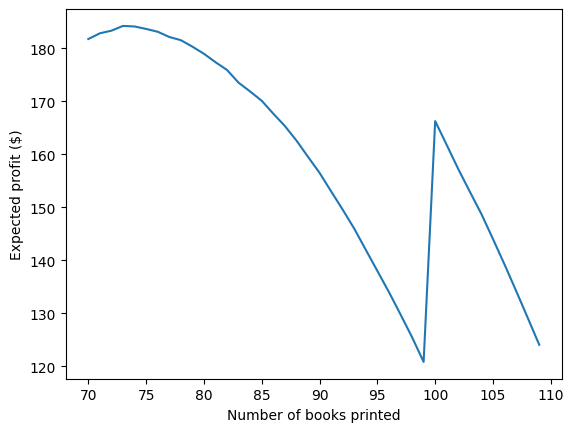

In [130]:
expected_profits.plot(xlabel="Number of books printed", ylabel="Expected profit ($)")

In [131]:
expected_profits.idxmax(), expected_profits.max() # Ideal order, and profit associated with that order

(np.int64(73), np.float64(184.254))

In [132]:
# So now we choose a prior
# In the solution the prior is log-uniform from 1 to 100 books/week

qs = np.logspace(0, 2, 101)
prior = Pmf(1, qs)
prior.normalize()

np.int64(101)

<Axes: xlabel='Book ordering rate ($\\lambda$)', ylabel='CDF'>

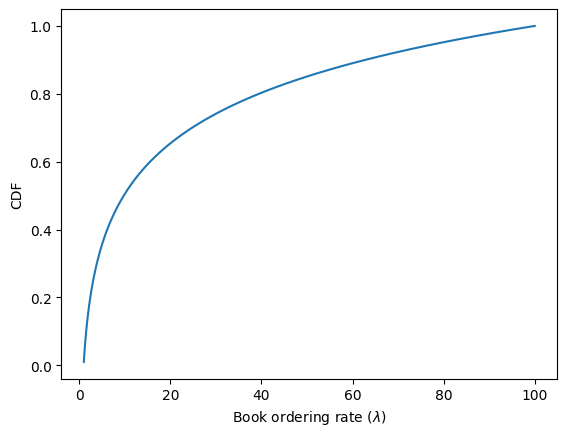

In [133]:
prior.make_cdf().plot(xlabel="Book ordering rate ($\lambda$)", ylabel="CDF")

In [134]:
# Then we use a function that updates the book ordering rate

from scipy.stats import poisson

def update_book(pmf, data):
    k = data
    lams = pmf.index
    likelihood = poisson.pmf(k, lams)
    pmf *= likelihood
    pmf.normalize()

In [136]:
# Update after week 1

posterior1 = prior.copy()
update_book(posterior1, 10)

In [137]:
# And after week 2

posterior2 = posterior1.copy()
update_book(posterior2, 9)

In [138]:
prior.mean(), posterior1.mean(), posterior2.mean()

(np.float64(21.78849107458653),
 np.float64(10.000000817984526),
 np.float64(9.500000000003652))

In [139]:
# Now we generate a sample of values from the posterior

rates = posterior2.choice(1000)
np.mean(rates)

np.float64(9.394915047830535)

In [140]:
# And then a sequence of 8 weeks for each value

order_array = np.random.poisson(rates, size=(8, 1000)).transpose()
order_array[:5, :]

array([[12, 18, 14,  5, 16, 10, 19, 11],
       [10, 11, 11, 10, 11, 20,  3, 10],
       [10, 10,  9, 11, 11,  6, 11,  8],
       [ 7,  9,  7,  6, 15, 12, 11, 14],
       [ 3, 10, 10,  7,  6,  9, 16,  8]])

In [141]:
printed_array = np.arange(70, 110)
t = [compute_expected_profits(printed, order_array) for printed in printed_array]
expected_profits = pd.Series(t, printed_array)

<Axes: xlabel='Number of books printed', ylabel='Expected profit ($)'>

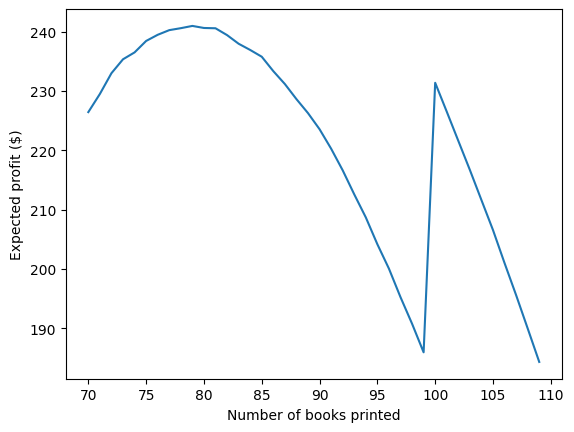

In [142]:
expected_profits.plot(xlabel="Number of books printed", ylabel="Expected profit ($)")

In [143]:
expected_profits.idxmax(), expected_profits.max()

(np.int64(79), np.float64(240.982))